# Portfolio Optimization

In this section, we present a portfolio optimization example where we seek to minimize the risk-adjusted expected return of a portfolio while adhering to specific investment constraints. This problem can be written as

$$
\begin{aligned}
& \text{minimize} && \frac{1}{2} x^T (\gamma P) x + q^T x \\
& \text{subject to} && 1^T x \leq 1, \\
&&& 0 \leq x \leq x_\mathrm{max}, \\
&&& \text{CVaR}_{\beta}(Ax) \leq \kappa,
\end{aligned}
$$

where the decision variable $x \in \mathbb{R}^n$ represents the fraction of total capital invested in each asset. The objective function combines the expected return of the portfolio, represented by $q^T x$, with a term that accounts for the risk (variance) of the portfolio, represented by $\frac{1}{2} x^T (\gamma P) x$. The constraints ensure that:

1. The total investment does not exceed 100% of the available capital.
2. Each investment is bounded by an upper limit, promoting diversification.
3. The Conditional Value at Risk (CVaR) of the portfolio's losses does not exceed a specified threshold at the $\beta$ quantile, controlling for potential extreme losses in the worst-case scenarios.

## Data generation

The data for this problem is generated using a Gaussian mixture model (GMM), which introduces complexity and realism into the simulation by modeling the returns of the assets. The GMM consists of two components:
- The first component, with a mean of 0.2 and a weight of 0.8, represents assets with moderate positive returns.
- The second component, with a mean of -0.2 and a weight of 0.2, includes riskier assets with negative returns. The variance of this component is scaled by a factor of $\sigma$, indicating higher volatility.

This synthetic setup allows us to test the optimization framework under controlled yet challenging conditions that mimic real-world financial markets with a mix of asset returns and volatilities.

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cvxpy as cp
import tqdm as tqdm
from admm import run_admm
%load_ext pyinstrument

# autoreload for debugging
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

## Data generation

In [3]:
# generate a gaussian mixture model with 2 components, one with weight .8 and
# the other with weight .2. The mean of the first should be .2, and the mean of 
# the second should be -.2. There should be d dimensions, and the covariance is
# the identity in the first, and sigma * identity in the second.
def generate_gmm(m, d, sigma):
    X = np.random.randn(m, d)
    y = np.random.binomial(1, .8, m)
    X[y == 1] += .2
    X[y == 0] -= .2
    X[y == 0] *= sigma

    # compute the empirical covariance matrix
    P = np.cov(X.T)
    # compute the mean of the data
    q = np.mean(X, axis=0)
    
    return -X, P, -q

In [4]:
np.random.seed(0)
m = 100_000
d = 3000
A, P, q = generate_gmm(m, d, 2)

beta = .1
kappa = .2

k = int(beta * m)
alpha = kappa * k

gamma = .05

A_box = np.eye(d)
A_total = np.ones((1, d))

def box_prox(z):
    return np.clip(z, 0, lim)

def total_prox(z):
    return np.clip(z, 0, 1)

proj_As = [A_box, A_total]
proj_fns = [box_prox, total_prox]

lim = 1
def gen_constraints(x):
    return [
        0 <= cp.sum(x), cp.sum(x) <= 1,
        0 <= x, x <= lim,
    ]

def gen_objective(x):
    return cp.Minimize(.5 * cp.quad_form(x, gamma*P) + q @ x)

In [5]:
q.max(), q.min(), kappa, A.max(), A.min()

(-0.06793979616621217,
 -0.09436332949747886,
 0.2,
 11.800678200133687,
 -10.75158468111684)

## Solution via CVXPY

In [6]:
# solve the problem with cvxpy for reference
x_cvxpy = cp.Variable(d)
objective = gen_objective(x_cvxpy)
constraints = gen_constraints(x_cvxpy)
constraints += [
    cp.sum_largest(A@x_cvxpy, k) <= alpha,
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND)
print("Optimal value: ", prob.value)
print("CVaR and limit: ", np.sort(A @ x_cvxpy.value)[::-1][:k].sum() / m, kappa)
print("Solve time: ", prob._solve_time)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) May 09 04:06:20 PM: Your problem has 3000 variables, 5 constraints, and 0 parameters.
(CVXPY) May 09 04:06:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 04:06:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 04:06:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 09 04:06:22 PM: Your problem is compiled with the SCIPY canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 04:06:22 PM: Compiling problem (target solver=MOSEK).

Solve time:  494.010137796402


In [7]:
prob.solve(solver=cp.OSQP, verbose=True,canon_backend=cp.SCIPY_CANON_BACKEND)
print("Optimal value: ", prob.value)
print("CVaR and limit: ", np.sort(A @ x_cvxpy.value)[::-1][:k].sum() / m, kappa)
print("Solve time: ", prob._solve_time)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) May 08 01:29:02 PM: Your problem has 6000 variables, 5 constraints, and 0 parameters.


(CVXPY) May 08 01:29:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 08 01:29:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 08 01:29:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 08 01:29:08 PM: Your problem is compiled with the SCIPY canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 08 01:29:08 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 08 01:29:08 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) May 08 01:29:08 PM: Applying reduction CvxAttr2Constr
(CVXPY) May 08 01:29:08 PM: Applying reduction Qp2SymbolicQp
(CVXPY) May 08 01:29:08 PM

: 

## Solution via ADMM

In [18]:
# warm start with fewer scenarios
m_ = 1_000
A_ = A[:m_]
k_ = int(beta * m_)
alpha_ = kappa * k_
x_cvxpy_ = cp.Variable(d)

objective_ = gen_objective(x_cvxpy_)
constraints_ = gen_constraints(x_cvxpy_)
constraints_ += [
    cp.sum_largest(A_@x_cvxpy_, k_) <= alpha_ , 
]
prob_ = cp.Problem(objective_, constraints_)
prob_.solve(solver=cp.MOSEK)
print(prob_.value)
print(np.sort(A_ @ x_cvxpy_.value)[::-1][:k].sum() / m_, kappa)

-0.08201275674131327
-0.12281584090528178 0.2


In [ ]:
# %%pyinstrument

x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, 
     max_iter=2_000, 
     alpha_over=1.7, rho=.1, 
     warm=None, #x_cvxpy_.value, 
     verbose = True,
     constraint_func=gen_constraints
)

print(history["objval"][-1])
print(np.sort(A @ x)[::-1][:k].sum() / m, kappa)

print("relative objective error: ", abs(history["objval"][-1] - prob.value) / abs(prob.value))

In [9]:
# %%pyinstrument

x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, 
     max_iter=2_000, 
     alpha_over=1.7, rho=.1, 
    #  warm=x_cvxpy_.value, 
     verbose = True,
    #  constraint_func=gen_constraints
)

print(history["objval"][-1])
print(np.sort(A @ x)[::-1][:k].sum() / m, kappa)

print("relative objective error: ", abs(history["objval"][-1] - prob.value) / abs(prob.value))

iter: 0, objval: -0.00017535722971322921, r_norm: 0.008667758766168302, s_norm: 0.7587376090584006, u_norm: 0.0002399623731281577, time: 14.009773015975952
iter: 100, objval: -0.032882070023165566, r_norm: 0.01357188809232599, s_norm: 0.8202004604775183, u_norm: 0.8118906571137618, time: 24.698251962661743
iter: 200, objval: -0.03887610367833019, r_norm: 0.004537334805197238, s_norm: 0.008176827725821791, u_norm: 0.7467684108021986, time: 35.187129974365234
iter: 300, objval: -0.039849922822510514, r_norm: 0.0016721147744107696, s_norm: 0.006449460151479708, u_norm: 0.555558494554904, time: 45.00937485694885
iter: 400, objval: -0.0397650050167156, r_norm: 0.0010107900894718441, s_norm: 0.0024508930250051846, u_norm: 0.5825393798210625, time: 54.81595182418823
ADMM terminated after  400  iterations
Time:  54.92170786857605
-0.0397650050167156
0.020000692807427865 0.2
relative objective error:  0.003505997620924989


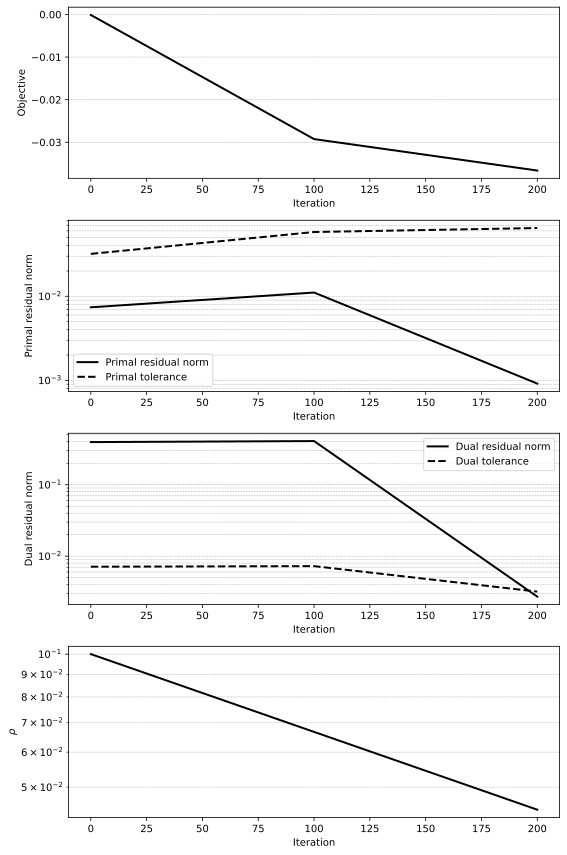

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Objective value
axs[0].plot(history['iter'], history['objval'], 'k', markersize=10, linewidth=2, label="ADMM")
axs[0].set_ylabel("Objective")
axs[0].set_xlabel('Iteration')
axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Primal residual norm
axs[1].semilogy(history['iter'], history['r_norm'], 'k', linewidth=2, label="Primal residual norm")
axs[1].semilogy(history['iter'], history['eps_pri'], 'k--', linewidth=2, label="Primal tolerance")
axs[1].set_ylabel(r'Primal residual norm')
axs[1].set_xlabel('Iteration')
axs[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
axs[1].legend()

# Dual residual norm
axs[2].semilogy(history['iter'], history['s_norm'], 'k', linewidth=2, label="Dual residual norm")
axs[2].semilogy(history['iter'], history['eps_dual'], 'k--', linewidth=2, label="Dual tolerance")
axs[2].set_ylabel(r'Dual residual norm')
axs[2].set_xlabel('Iteration')
axs[2].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
axs[2].legend()


# ADMM penalty parameter
axs[3].semilogy(history['iter'], history['rho'], 'k', linewidth=2, label="ADMM 1.0")
axs[3].set_ylabel(r'$\rho$')
axs[3].set_xlabel('Iteration')
axs[3].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [9]:
x.min(), x.max(), x.sum(), x_cvxpy.value.min(), x_cvxpy.value.max(), x_cvxpy.value.sum()

(-8.628572249386643e-05,
 0.0019064795722552861,
 0.4436408295217871,
 1.4196733738057856e-08,
 0.001807553427201502,
 0.4435903935263111)

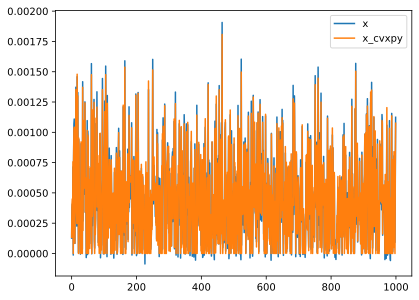

In [10]:
plt.plot(x, label="x")
plt.plot(x_cvxpy.value, label="x_cvxpy")
plt.legend()

## Runtime comparisons

In [5]:
d = 6000
scenarios = [10_000, 50_000, 100_000]
solve_times_cvxpy = []
solve_times_admm = []

for m in scenarios:
    print(f"Running for {m} scenarios")
    # Data generation
    A, P, q = generate_gmm(m, d, 2)
    k = int(beta * m)
    alpha = kappa * k
    A_box = np.eye(d)
    A_total = np.ones((1, d))
    proj_As = [A_box, A_total]
    def gen_objective(x):
        return cp.Minimize(.5 * cp.quad_form(x, gamma*P) + q @ x)
    
    # Solution via CVXPY
    x_cvxpy = cp.Variable(d)
    objective = gen_objective(x_cvxpy)
    constraints = gen_constraints(x_cvxpy)
    constraints += [
        cp.sum_largest(A@x_cvxpy, k) <= alpha ,
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK, verbose=False, canon_backend=cp.SCIPY_CANON_BACKEND)
    solver_time = prob._solve_time
    solve_times_cvxpy.append(solver_time)
    print("\tCVXPY solve time: ", solver_time)
    
    # Solution via ADMM
    ts = time.time()
    x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, 
     max_iter=10000, 
     alpha_over=1.7, rho=.1, 
     warm=None, #x_cvxpy_.value, 
     verbose=False,
     # constraint_func=gen_constraints
)
    te = time.time()
    solve_times_admm.append(te - ts)
    print("\tADMM solve time: ", te - ts)

Running for 10000 scenarios
	CVXPY solve time:  348.12089705467224
ADMM terminated after  500  iterations
Time:  45.63476300239563
	ADMM solve time:  45.747560024261475
Running for 50000 scenarios
	CVXPY solve time:  840.6309690475464
ADMM terminated after  400  iterations
Time:  64.38518404960632
	ADMM solve time:  65.68233489990234
Running for 100000 scenarios
	CVXPY solve time:  4009.525491952896
ADMM terminated after  200  iterations
Time:  74.14267921447754
	ADMM solve time:  75.39672923088074


In [8]:
# pickle the scenarios and solve times
import pickle
data = {
    "scenarios": scenarios,
    "solve_times_cvxpy": solve_times_cvxpy,
    "solve_times_admm": solve_times_admm,
}
with open("solve_times.pkl", "wb") as f:
    pickle.dump(data, f)


In [9]:
# load the results
import pickle

with open("solve_times.pkl", "rb") as f:
    data = pickle.load(f)

scenarios = data["scenarios"]
solve_times_cvxpy = data["solve_times_cvxpy"]
solve_times_admm = data["solve_times_admm"]

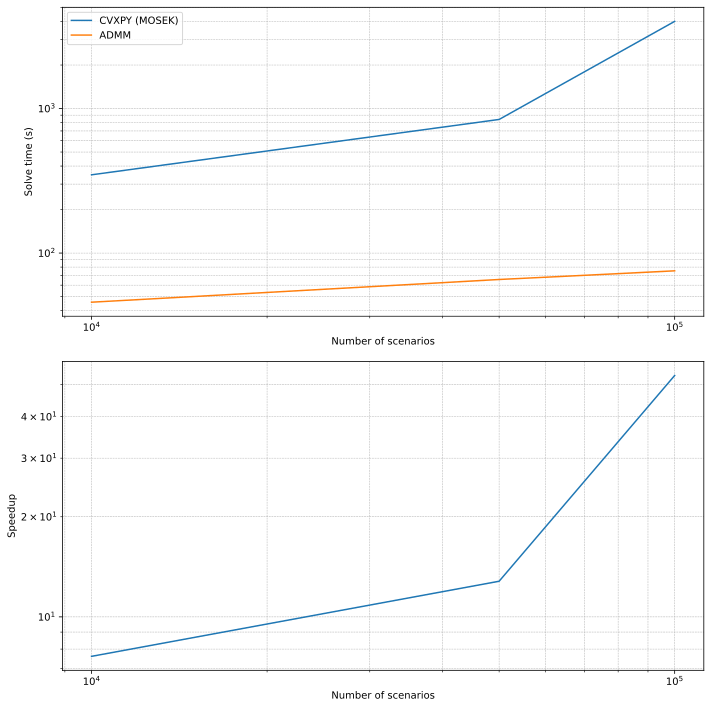

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.loglog(scenarios, solve_times_cvxpy, label="CVXPY (MOSEK)")
ax1.loglog(scenarios, solve_times_admm, label="ADMM")
ax1.set_xlabel("Number of scenarios")
ax1.set_ylabel("Solve time (s)")
ax1.legend()
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

speedups = [cvxpy_time / admm_time for cvxpy_time, admm_time in zip(solve_times_cvxpy, solve_times_admm)]
ax2.loglog(scenarios, speedups)
ax2.set_xlabel("Number of scenarios")
ax2.set_ylabel("Speedup")
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

# plt.savefig("../cvar-opt/portfolio_experiment.pdf")

In [8]:
scenarios

[10000, 50000, 100000]